##Imports

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import seaborn as sns
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import ShuffleSplit
from scipy.sparse import hstack
from sklearn.metrics import r2_score

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

lemmatiser = WordNetLemmatizer()
# Defining a module for Text Processing
def text_process(tex):
    # 1. Removal of Punctuation Marks 
    nopunct=[char for char in tex if char not in string.punctuation and char.isalnum() or char == " "]
    nopunct=''.join(nopunct)
    # 2. Lemmatisation 
    a=''
    i=0
    for i in range(len(nopunct.split())):
        b=lemmatiser.lemmatize(nopunct.split()[i].lower())
        a=a+b+' '

    return a

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


##Looking at data

In [ ]:
test = pd.read_csv("lego_test.csv")
train = pd.read_csv("lego_train.csv")

In [ ]:
test.head()

,prod_id,set_name,prod_desc,theme_name,piece_count,min_age,max_age,difficulty_level,num_reviews,star_rating,list_price
0,10744,Thunder Hollow Crazy 8 Race,Roll up for a demolition derby at the Disney•P...,Juniors,191,4.0,7.0,2,2.0,5.0,34.99
1,70358,Aaron's Stone Destroyer,Protect Robot Hoodlum from The Bedrock Monster!,NEXO KNIGHTS™,251,8.0,14.0,2,1.0,5.0,24.99
2,42060,Roadwork Crew,Call in the Roadwork Crew!,Technic,365,8.0,14.0,1,10.0,4.8,29.99
3,75877,Mercedes-AMG GT3,Customize the awesome AMG GT3 to race!,Speed Champions,196,7.0,14.0,1,12.0,4.6,14.99
4,76101,Outrider Dropship Attack,Defend Wakanda from attack with the Avengers!,Marvel Super Heroes,124,6.0,12.0,1,13.0,4.8,14.99


In [ ]:
train.head()

,prod_id,set_name,prod_desc,theme_name,piece_count,min_age,max_age,difficulty_level,num_reviews,star_rating,list_price
0,60123,Volcano Supply Helicopter,Fly in the exploration gear and fly out the cr...,City,330,7.0,12.0,1,3.0,4.3,49.990
1,71246,Adventure Time™ Team Pack,Explore the Land of Ooo with Jake and Lumpy Sp...,DIMENSIONS™,96,7.0,14.0,1,3.0,4.7,30.362
2,10616,My First Playhouse,Learn about daily routines with this easy-to-b...,DUPLO®,25,1.5,5.0,1,3.0,5.0,19.990
3,31079,Sunshine Surfer Van,Enjoy seaside fun with the 3-in-1 Sunshine Sur...,Creator 3-in-1,379,8.0,12.0,1,5.0,4.4,34.990
4,42057,Ultralight Helicopter,Take to the skies with the Ultralight Helicopter!,Technic,199,8.0,14.0,1,9.0,4.7,19.990


The number of samples in our dataset is quite small, which is one of the main obstacles in creating a model that generalizes well

In [ ]:
print("Train:",train.shape[0])
print("Test:",test.shape[0])

Train: 558
Test: 186


In [ ]:
for name in train.columns:
  print(name,len(train[name].unique()))

prod_id 558
set_name 554
prod_desc 545
theme_name 38
piece_count 367
min_age 13
max_age 8
difficulty_level 5
num_reviews 79
star_rating 24
list_price 58


In [ ]:
X_train = train.drop(['list_price','prod_id'], axis = 1) 
X_test = test.drop(['list_price','prod_id'], axis = 1) 
y_train = train['list_price']
y_test = test['list_price']

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   set_name          558 non-null    object 
 1   prod_desc         544 non-null    object 
 2   theme_name        558 non-null    object 
 3   piece_count       558 non-null    int64  
 4   min_age           558 non-null    float64
 5   max_age           558 non-null    float64
 6   difficulty_level  558 non-null    int64  
 7   num_reviews       490 non-null    float64
 8   star_rating       490 non-null    float64
dtypes: float64(4), int64(2), object(3)
memory usage: 39.4+ KB


In [ ]:
X_train.describe()

,piece_count,min_age,max_age,difficulty_level,num_reviews,star_rating
count,558.000000,558.000000,558.000000,558.000000,490.000000,490.000000
mean,432.806452,6.928315,27.577061,1.514337,16.857143,4.516327
std,730.305859,2.987146,33.747031,0.801015,36.654636,0.487826
min,1.000000,1.500000,3.000000,0.000000,1.000000,2.600000
25%,91.000000,5.000000,12.000000,1.000000,2.000000,4.300000
50%,199.500000,7.000000,14.000000,2.000000,6.000000,4.600000
75%,467.000000,8.000000,14.000000,2.000000,14.000000,5.000000
max,7541.000000,16.000000,99.000000,4.000000,367.000000,5.000000


Text(0.5, 1.0, 'Distribution of LEGO Set Prices')

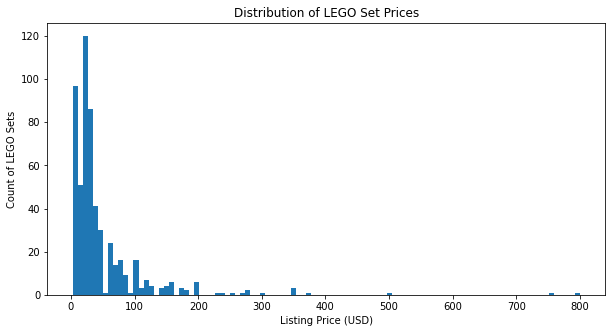

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(y_train, bins=100)

ax.set_xlabel("Listing Price (USD)")
ax.set_ylabel("Count of LEGO Sets")
ax.set_title("Distribution of LEGO Set Prices")

Let's look at how the features in our training dataset correlate

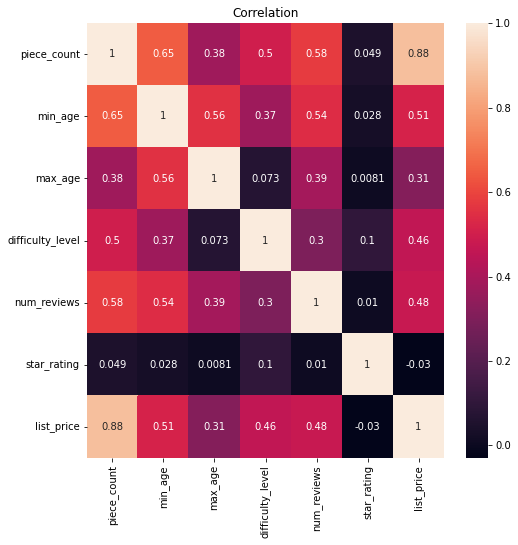

In [ ]:
corr = train.drop('prod_id', axis=1).corr()

fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(data=corr, annot=True)

ax.set_title("Correlation");

The strongest correlation is between our target variable list_price and the piece_count variable, which is understandable. The more pieces there are in a lego set, the more expensive it is to produce, hence the evident increase in price.

Let's see how linearly dependent piece_count and list_price are

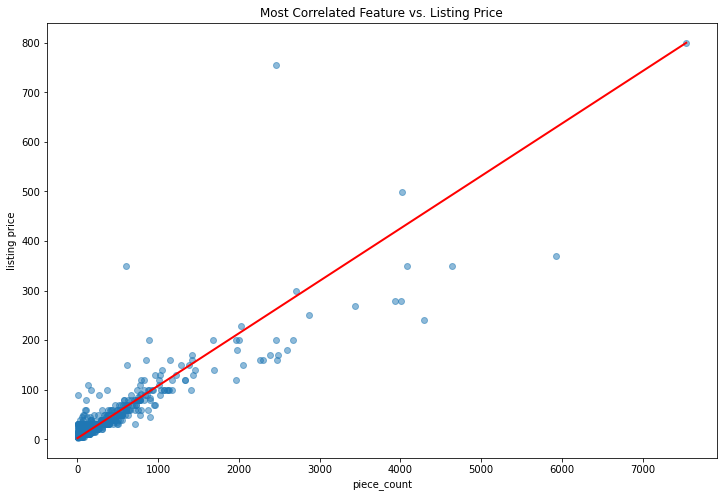

In [ ]:
most_correlated_feature = 'piece_count'

fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(X_train[most_correlated_feature], y_train, alpha=0.5)

ax.plot([X_train[most_correlated_feature].min(),X_train[most_correlated_feature].max()],[y_train.min(),y_train.max()],c='r', linewidth=2)
ax.set_xlabel(most_correlated_feature)
ax.set_ylabel("listing price")
ax.set_title("Most Correlated Feature vs. Listing Price");

The is a bunch of obvious outliers but the linearity is still there

##BASELINE

Let's build our baseline model with only the most_correlated feature and see how it performs

In [ ]:
splitter = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

clf = make_pipeline(StandardScaler(), LinearRegression())
scores = cross_validate(clf,X_train[[most_correlated_feature]], y_train,cv=splitter)

clf.fit(X_train[[most_correlated_feature]], y_train)

print("train score:", scores["test_score"].mean())
print("test score:", clf.score(X_test[[most_correlated_feature]], y_test))

train score: 0.804386710174855
test score: 0.6573784260450029


##PURE NUMERIC

Our dataset has numeric as well as textual features. Let's focus on only the numeric ones for now

In [ ]:
X_train_n = X_train.select_dtypes(include=np.number)
X_test_n = X_test.select_dtypes(include=np.number)

In [ ]:
X_train_n.head()

,piece_count,min_age,max_age,difficulty_level,num_reviews,star_rating
0,330,7.0,12.0,1,3.0,4.3
1,96,7.0,14.0,1,3.0,4.7
2,25,1.5,5.0,1,3.0,5.0
3,379,8.0,12.0,1,5.0,4.4
4,199,8.0,14.0,1,9.0,4.7


Such features as number of reviews or star rating are useless for us, since we wouldn't know them for any new lego sets, hence they should not be used in our regressor

In [ ]:
X_train_n = X_train_n.drop(["num_reviews","star_rating"],axis=1)
X_test_n = X_test_n.drop(["num_reviews","star_rating"],axis=1)

###Without feature selection

In [ ]:
X_train_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   piece_count       558 non-null    int64  
 1   min_age           558 non-null    float64
 2   max_age           558 non-null    float64
 3   difficulty_level  558 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 17.6 KB


We can see a slight improvement over our baseline model

In [ ]:
clf = make_pipeline(StandardScaler(), LinearRegression())
scores = cross_validate(clf,X_train_n, y_train,cv=splitter)

clf.fit(X_train_n, y_train)

print("train score:", scores["test_score"].mean())
print("test score:", clf.score(X_test_n, y_test))

train score: 0.7981116960692178
test score: 0.6690439363366967


###With feature selection

Instead of feeding all of our features to the model, let's try to find the optimal subset that will maximize the model's performance

In [ ]:
X2 = sm.add_constant(X_train_n)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             list_price   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     506.8
Date:                Sun, 19 Jun 2022   Prob (F-statistic):          2.40e-183
Time:                        10:52:04   Log-Likelihood:                -2741.4
No. Observations:                 558   AIC:                             5493.
Df Residuals:                     553   BIC:                             5514.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               22.0991      4.550  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Looking at the p-values leaves us with only two features

In [ ]:
significant_features = ['piece_count','min_age']

####Linear Regression

Unfortunately we can't see much of an improvement from our previous models

In [ ]:
linreg = make_pipeline(StandardScaler(), LinearRegression())
scores = cross_validate(linreg,X_train_n[significant_features], y_train,cv=splitter)

linreg.fit(X_train_n[significant_features], y_train)

print("train score:", scores["test_score"].mean())
print("test score:", linreg.score(X_test_n[significant_features], y_test))

train score: 0.7999976334497971
test score: 0.6698842694634576


Let's try recursive feature elimination instead. We will start with the full set of features and keep removing them one by one as long as performence of the model keeps increasing

In [ ]:
rfecv = RFECV(
    estimator=LinearRegression(),
    step=1,
    cv=5,
    min_features_to_select=1,
)

rfecv.fit(StandardScaler().fit_transform(X_train_n), y_train)

print("Optimal number of features : %d" % rfecv.n_features_)
print(rfecv.get_feature_names_out())

Optimal number of features : 1
['x0']


In [ ]:
linreg_optimal_features_idx = [int(i[1:]) for i in rfecv.get_feature_names_out()]

Wierdly enough, it seems that our baseline model is the most optimal linear regression model we can get. So instead of sticking to it, let's try other regressors and see how they perform

In [ ]:
linreg = make_pipeline(StandardScaler(), LinearRegression())
scores = cross_validate(linreg,X_train_n.iloc[:,linreg_optimal_features_idx], y_train,cv=splitter)

linreg.fit(X_train_n.iloc[:,linreg_optimal_features_idx], y_train)

print("train score:", scores["test_score"].mean())
print("test score:", linreg.score(X_test_n.iloc[:,linreg_optimal_features_idx], y_test))

train score: 0.804386710174855
test score: 0.6573784260450029


####LGBM Regressor

In [ ]:
lgbm = make_pipeline(StandardScaler(), LGBMRegressor())
scores = cross_validate(lgbm,X_train_n[significant_features], y_train,cv=splitter)

lgbm.fit(X_train_n[significant_features], y_train)

print("train score:", scores["test_score"].mean())
print("test score:", lgbm.score(X_test_n[significant_features], y_test))

train score: 0.7108118341964031
test score: 0.7679876193544546


In [ ]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(
    estimator=LGBMRegressor(),
    step=1,
    cv=5,
    min_features_to_select=1,
)

rfecv.fit(StandardScaler().fit_transform(X_train_n), y_train)

print("Optimal number of features : %d" % rfecv.n_features_)
print(rfecv.get_feature_names_out())

Optimal number of features : 3
['x0' 'x1' 'x2']


In [ ]:
lgbm_optimal_features_idx = [int(i[1:]) for i in rfecv.get_feature_names_out()]

In [ ]:
lgbm = make_pipeline(StandardScaler(), LGBMRegressor())
scores = cross_validate(lgbm,X_train_n.iloc[:,lgbm_optimal_features_idx], y_train,cv=splitter)

lgbm.fit(X_train_n.iloc[:,lgbm_optimal_features_idx], y_train)

print("train score:", scores["test_score"].mean())
print("test score:", lgbm.score(X_test_n.iloc[:,lgbm_optimal_features_idx], y_test))

train score: 0.7082553518869693
test score: 0.7954922620213274


####GradientBoostingRegressor

In [ ]:
gradboost = make_pipeline(StandardScaler(), GradientBoostingRegressor())
scores = cross_validate(gradboost,X_train_n[significant_features], y_train,cv=splitter)

gradboost.fit(X_train_n[significant_features], y_train)

print("train score:", scores["test_score"].mean())
print("test score:", gradboost.score(X_test_n[significant_features], y_test))

train score: 0.780152706344029
test score: 0.9100823867962803


In [ ]:
rfecv = RFECV(
    estimator=GradientBoostingRegressor(),
    step=1,
    cv=splitter,
    min_features_to_select=1,
)

rfecv.fit(StandardScaler().fit_transform(X_train_n), y_train)

print("Optimal number of features : %d" % rfecv.n_features_)
print(rfecv.get_feature_names_out())

Optimal number of features : 2
['x0' 'x1']


In [ ]:
gradboost_optimal_features_idx = [int(i[1:]) for i in rfecv.get_feature_names_out()]

In [ ]:
gradboost = make_pipeline(StandardScaler(), GradientBoostingRegressor())
scores = cross_validate(gradboost,X_train_n.iloc[:,gradboost_optimal_features_idx], y_train,cv=splitter)

gradboost.fit(X_train_n.iloc[:,gradboost_optimal_features_idx], y_train)

print("train score:", scores["test_score"].mean())
print("test score:", gradboost.score(X_test_n.iloc[:,gradboost_optimal_features_idx], y_test))

train score: 0.7814561350826622
test score: 0.9135543407311597


####CatBoost

In [ ]:
catboost = make_pipeline(StandardScaler(), CatBoostRegressor(verbose=False))
scores = cross_validate(catboost,X_train_n[significant_features], y_train,cv=splitter)

catboost.fit(X_train_n[significant_features], y_train)

print("train score:", scores["test_score"].mean())
print("test score:", catboost.score(X_test_n[significant_features], y_test))

train score: 0.7395652516019526
test score: 0.9278689584612778


In [ ]:
rfecv = RFECV(
    estimator=CatBoostRegressor(verbose=False),
    step=1,
    cv=splitter,
    min_features_to_select=1,
)

rfecv.fit(StandardScaler().fit_transform(X_train_n), y_train)

print("Optimal number of features : %d" % rfecv.n_features_)
print(rfecv.get_feature_names_out())

Optimal number of features : 2
['x0' 'x1']


In [ ]:
catboost_optimal_features_idx = [int(i[1:]) for i in rfecv.get_feature_names_out()]

In [ ]:
catboost = make_pipeline(StandardScaler(), CatBoostRegressor(verbose=False))
scores = cross_validate(catboost,X_train_n.iloc[:,catboost_optimal_features_idx], y_train,cv=splitter)

catboost.fit(X_train_n.iloc[:,catboost_optimal_features_idx], y_train)

print("train score:", scores["test_score"].mean())
print("test score:", catboost.score(X_test_n.iloc[:,catboost_optimal_features_idx], y_test))

train score: 0.7395652516019526
test score: 0.9278689584612778


##USING TEXT

Let's try improving our models by extracting useful information from the textual data present in our dataset

Unfortunately we can't do much owing to the fact that our dataset is quite small. So trying to use product description and set name didn't lead to any improvements. But the theme_name feature proved to be rather useful.  

The theme of a particular lego set the target demographic as well as the types of lego pieces that go into the set, which directly influences the price. Also the theme may indicate some additinal costs like licensing fees for sets that are made for a particular franchise like Marvel or Star Wars 

Instead of working with theme name as a categorical feature, we treat it as textual data and encode it using count vectorizer. The logic behind this is that in cases like 'THE LEGO® NINJAGO® MOVIE™' and 'NINJAGO®' we would like them to be treated similiarly, since they belong to the same franchise. This will also somewhat help us deal with the theme names that weren't present in our training data. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

bow_transformer_theme = CountVectorizer(analyzer="word",ngram_range=(1,2), stop_words=stopwords.words('english')).fit(X_train['theme_name'])

train_theme = bow_transformer_theme.transform(X_train['theme_name'])
test_theme = bow_transformer_theme.transform(X_test['theme_name'])

In [ ]:
train_theme.shape

(558, 62)

Or we can still use one hot encoding if you prefer, the performance doesn't change much

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
onehot = OneHotEncoder(
    categories='auto',  # Categories per feature
    drop=None, # Whether to drop one of the features
    sparse=True, # Will return sparse matrix if set True
    handle_unknown='ignore' # Whether to raise an error 
)         

In [ ]:
train_theme = onehot.fit_transform(pd.DataFrame(X_train['theme_name']))
test_theme = onehot.transform(pd.DataFrame(X_test['theme_name']))

###Linear regression

Even with the simple linear regression model we can see a clear boost in performance on the test dataset

In [ ]:
X_train_sparse = hstack((X_train_n.iloc[:,linreg_optimal_features_idx], train_theme)).tocsr()
X_test_sparse = hstack((X_test_n.iloc[:,linreg_optimal_features_idx], test_theme)).tocsr()

linreg = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
scores = cross_validate(linreg,X_train_sparse, y_train,cv=splitter)

linreg.fit(X_train_sparse, y_train)

print("train score:", scores["test_score"].mean())
print("test score:", linreg.score(X_test_sparse, y_test))

train score: 0.5359272634553246
test score: 0.823448644933637


###LGBM regression

In [ ]:
X_train_sparse = hstack((X_train_n.iloc[:,lgbm_optimal_features_idx], train_theme)).tocsr()
X_test_sparse = hstack((X_test_n.iloc[:,lgbm_optimal_features_idx], test_theme)).tocsr()

lgbm = make_pipeline(StandardScaler(with_mean=False), LGBMRegressor())
scores = cross_validate(lgbm,X_train_sparse, y_train,cv=splitter)

lgbm.fit(X_train_sparse, y_train)

print("train score:", scores["test_score"].mean())
print("test score:", lgbm.score(X_test_sparse, y_test))

train score: 0.6912739610401548
test score: 0.7783491647107945


###GradBoostingRegressor

In [ ]:
X_train_sparse = hstack((X_train_n.iloc[:,gradboost_optimal_features_idx], train_theme)).tocsr()
X_test_sparse = hstack((X_test_n.iloc[:,gradboost_optimal_features_idx], test_theme)).tocsr()

gradboost = make_pipeline(StandardScaler(with_mean=False), GradientBoostingRegressor())
scores = cross_validate(gradboost,X_train_sparse, y_train,cv=splitter)

gradboost.fit(X_train_sparse, y_train)

print("train score:", scores["test_score"].mean())
print("test score:", gradboost.score(X_test_sparse, y_test))

train score: 0.8117428147952459
test score: 0.9414876537112025


In [ ]:
gradboost_optimal_features_idx_text = [i for i in range(X_train_sparse.shape[1])]

In [ ]:
rfecv = RFECV(
    estimator=GradientBoostingRegressor(),
    step=1,
    cv=splitter,
    min_features_to_select=1,
)

rfecv.fit(StandardScaler(with_mean=False).fit_transform(X_train_sparse), y_train)

print("Optimal number of features : %d" % rfecv.n_features_)
print(rfecv.get_feature_names_out())

Optimal number of features : 34
['x0' 'x1' 'x4' 'x7' 'x11' 'x12' 'x14' 'x15' 'x17' 'x18' 'x21' 'x22' 'x28'
 'x29' 'x30' 'x31' 'x34' 'x35' 'x46' 'x55' 'x56' 'x57' 'x60' 'x61' 'x64'
 'x65' 'x66' 'x67' 'x72' 'x82' 'x83' 'x86' 'x87' 'x95']


In [ ]:
gradboost_optimal_features_idx_text = [int(i[1:]) for i in rfecv.get_feature_names_out()]

In [ ]:
gradboost = make_pipeline(StandardScaler(with_mean=False), GradientBoostingRegressor())
scores = cross_validate(gradboost,X_train_sparse[:,gradboost_optimal_features_idx_text], y_train,cv=splitter)

gradboost.fit(X_train_sparse[:,gradboost_optimal_features_idx_text], y_train)

print("train score:", scores["test_score"].mean())
print("test score:", gradboost.score(X_test_sparse[:,gradboost_optimal_features_idx_text], y_test))

train score: 0.8054278182035034
test score: 0.9418782840208186


###Catboost

In [ ]:
X_train_sparse = hstack((X_train_n.iloc[:,catboost_optimal_features_idx], train_theme)).tocsr()
X_test_sparse = hstack((X_test_n.iloc[:,catboost_optimal_features_idx], test_theme)).tocsr()

catboost = make_pipeline(StandardScaler(with_mean=False), CatBoostRegressor(verbose=False))
scores = cross_validate(catboost,X_train_sparse, y_train,cv=splitter)

catboost.fit(X_train_sparse, y_train)

print("train score:", scores["test_score"].mean())
print("test score:", catboost.score(X_test_sparse, y_test))

train score: 0.701305680854499
test score: 0.9425562390792604


##Final model

The model with the best overall performance is the gradient boosting regressor

In [ ]:
final_model = gradboost

Let's take a closer look at how far our predictions are from the truth

In [ ]:
preds = final_model.predict(X_test_sparse[:,gradboost_optimal_features_idx_text])
difference_percent = []
difference_absolute = []
print('Overpriced:', sum(y_test<preds), "Underpriced", sum(y_test>preds), "Total:", preds.shape[0])
id = 0
for pair in zip(y_test, preds):
  difference_percent.append(round((pair[1] - pair[0]) / pair[0] * 100, 2))
  difference_absolute.append(round(pair[1] - pair[0], 2))
  print(f"id:", id,'Actual:', pair[0], 'Predicted:', round(pair[1], 2), "Difference:", difference_absolute[-1], f"| {difference_percent[-1]}%")
  id+=1

Overpriced: 109 Underpriced 77 Total: 186
id: 0 Actual: 34.99 Predicted: 23.95 Difference: -11.04 | -31.56%
id: 1 Actual: 24.99 Predicted: 20.87 Difference: -4.12 | -16.5%
id: 2 Actual: 29.99 Predicted: 36.64 Difference: 6.65 | 22.16%
id: 3 Actual: 14.99 Predicted: 19.81 Difference: 4.82 | 32.16%
id: 4 Actual: 14.99 Predicted: 17.88 Difference: 2.89 | 19.27%
id: 5 Actual: 24.99 Predicted: 14.43 Difference: -10.56 | -42.24%
id: 6 Actual: 60.7924 Predicted: 38.14 Difference: -22.65 | -37.26%
id: 7 Actual: 29.99 Predicted: 32.44 Difference: 2.45 | 8.17%
id: 8 Actual: 9.99 Predicted: 15.33 Difference: 5.34 | 53.42%
id: 9 Actual: 19.99 Predicted: 18.21 Difference: -1.78 | -8.88%
id: 10 Actual: 24.99 Predicted: 21.0 Difference: -3.99 | -15.98%
id: 11 Actual: 24.99 Predicted: 21.54 Difference: -3.45 | -13.8%
id: 12 Actual: 9.99 Predicted: 14.21 Difference: 4.22 | 42.28%
id: 13 Actual: 19.99 Predicted: 19.77 Difference: -0.22 | -1.12%
id: 14 Actual: 79.99 Predicted: 100.25 Difference: 20.26 | 

Looking at the chart below it is easy to see that our predictions are generally not too bad, except for two glaring mistakes

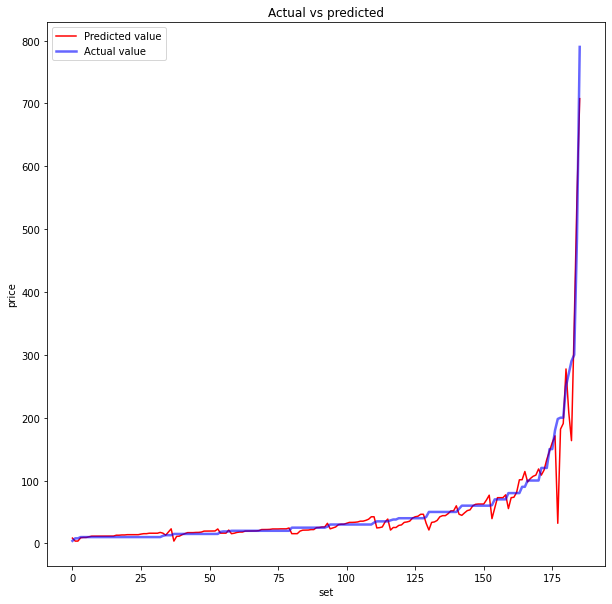

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot([x for _, x in sorted(zip(y_test, preds))], linewidth=1.5, c='r', alpha=1, label='Predicted value')
ax.plot(sorted(y_test), linewidth=2.5, c='b', alpha=0.6, label="Actual value")
ax.legend()
ax.set_xlabel('set')
ax.set_ylabel("price")
ax.set_title("Actual vs predicted");

The error below means that on average we are off by about 5 dollars

In [ ]:
print(f"RMSE: {mean_squared_error(y_test, final_model.predict(X_test_sparse[:,gradboost_optimal_features_idx_text]), squared=False)}")

RMSE: 19.502073003908404


In [ ]:
print(f"R2 score: {r2_score(y_test, final_model.predict(X_test_sparse[:,gradboost_optimal_features_idx_text]))}")

R2 score: 0.9414876537112025


In [ ]:
print(f"Median difference in price: {np.round(np.median(np.abs(difference_absolute)),3)}$ | {np.round(np.median(np.abs(difference_percent)),3)}%")

Median difference in price: 4.465$ | 16.25%


In [ ]:
print(f"Mean difference in price: {np.round(np.mean(np.abs(difference_absolute)),3)}$ | {np.round(np.mean(np.abs(difference_percent)),3)}%")

Mean difference in price: 8.582$ | 21.219%


In [ ]:
print(f"Price median: {np.round(y_test.median(),3)}$ | Price mean: {np.round(y_test.mean(),3)}$")

Price median: 25.795$ | Price mean: 50.066$


We can see that as the prices of sets increase our mistakes become less noticably relative to the price, but the absolute value increases

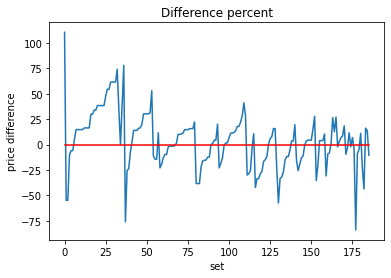

In [ ]:
fig, ax = plt.subplots()

ax.plot([x for _, x in sorted(zip(y_test, difference_percent))])
ax.plot([0]*len(difference_percent), c='r')
ax.set_xlabel('set')
ax.set_ylabel("price difference")
ax.set_title("Difference percent");

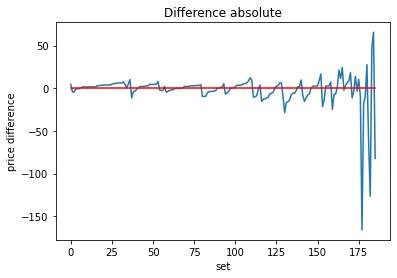

In [ ]:
fig, ax = plt.subplots()

ax.plot([x for _, x in sorted(zip(y_test, difference_absolute))])
ax.plot([0]*len(difference_percent), c='r')
ax.set_xlabel('set')
ax.set_ylabel("price difference")
ax.set_title("Difference absolute");

Let's take a look at the two most problematic lego sets for which our model's accuracy abnormaly low

It is quite obvious what went wrong here. This lego set has only one piece, yet it costs almost 200$. This happens cause our model mainly realise on number of pieces, and doesn't take into account what those pieces are

In [ ]:
print(X_test.iloc[169])
print('Actual price:', y_test[169])
print('Predicted price', preds[169])

set_name            EV3 Intelligent Brick
prod_desc                             NaN
theme_name                    MINDSTORMS®
piece_count                             1
min_age                              10.0
max_age                              21.0
difficulty_level                        2
num_reviews                           1.0
star_rating                           4.0
Name: 169, dtype: object
Actual price: 197.99
Predicted price 32.27436302353681


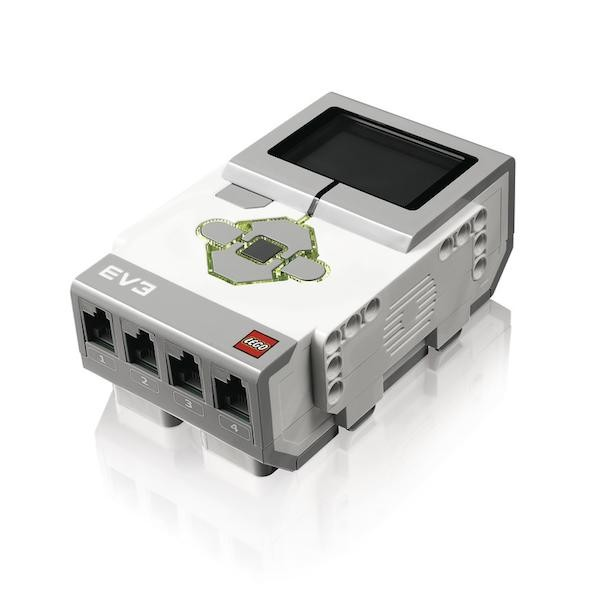

The second one is less jarring. It has quite a few pieces so our model is less off, but according to our model this set is still too expensive. Once again due to the types of pieces and not their amount

In [ ]:
print(X_test.iloc[148])
print('Actual price:', y_test[148])
print('Predicted price', preds[148])

set_name                                    6x6 All Terrain Tow Truck
prod_desc           Harness the power of the mighty 6x6 All Terrai...
theme_name                                                    Technic
piece_count                                                      1862
min_age                                                          11.0
max_age                                                          16.0
difficulty_level                                                    3
num_reviews                                                      45.0
star_rating                                                       3.5
Name: 148, dtype: object
Actual price: 289.99
Predicted price 164.99936745814625


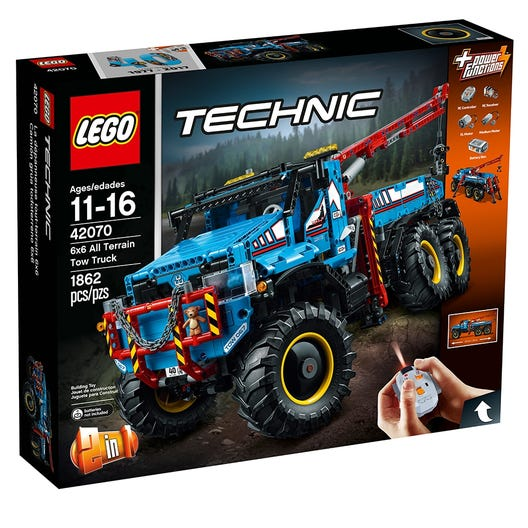

Let's try removing them and see what happens

In [ ]:
test_theme_ = bow_transformer_theme.transform(X_test['theme_name'].drop([148,169]))
X_test_sparse_ = hstack((X_test_n.iloc[:,gradboost_optimal_features_idx].drop([148,169]), test_theme_)).tocsr()
preds_without_outliers = final_model.predict(X_test_sparse_[:,gradboost_optimal_features_idx_text])
y_test_ = y_test.drop([148,169])

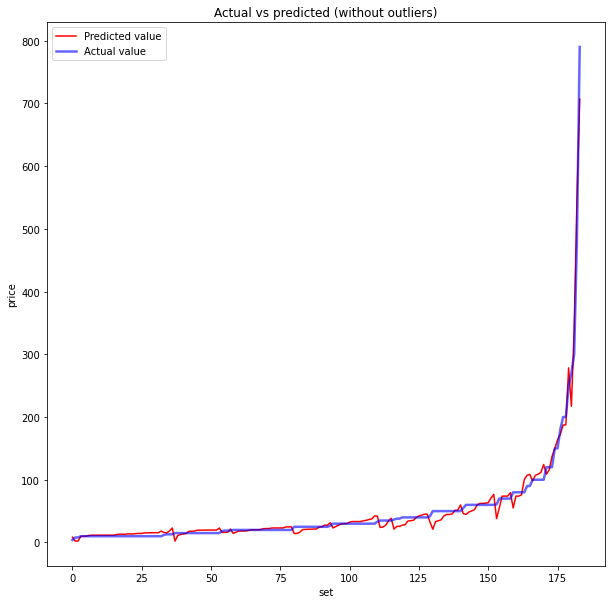

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot([x for _, x in sorted(zip(y_test_, preds_without_outliers))], linewidth=1.5, c='r', alpha=1, label='Predicted value')
ax.plot(sorted(y_test_), linewidth=2.5, c='b', alpha=0.6, label="Actual value")
ax.legend()
ax.set_xlabel('set')
ax.set_ylabel("price")
ax.set_title("Actual vs predicted (without outliers)");

In [ ]:
final_model.score(X_test_sparse_[:,gradboost_optimal_features_idx_text], y_test_)

0.9762191192076769

In [ ]:
preds = final_model.predict(X_test_sparse_[:,gradboost_optimal_features_idx_text])
difference_percent_ = []
difference_absolute_ = []
for pair in zip(y_test_, preds):
  difference_percent_.append(round((pair[1] - pair[0]) / pair[0] * 100, 2))
  difference_absolute_.append(round(pair[1] - pair[0], 2))

In [ ]:
print(f"RMSE: {mean_squared_error(y_test_, final_model.predict(X_test_sparse_[:,gradboost_optimal_features_idx_text]), squared=False)}")

RMSE: 12.07819156481589


In [ ]:
print(f"R2 score: {r2_score(y_test_, final_model.predict(X_test_sparse_[:,gradboost_optimal_features_idx_text]))}")

R2 score: 0.9762191192076769


In [ ]:
print(f"Median difference in price: {np.round(np.median(np.abs(difference_absolute_)),3)}$ | {np.round(np.median(np.abs(difference_percent_)),3)}%")

Median difference in price: 4.465$ | 16.08%


In [ ]:
print(f"Mean difference in price: {np.round(np.mean(np.abs(difference_absolute_)),3)}$ | {np.round(np.mean(np.abs(difference_percent_)),3)}%")

Mean difference in price: 7.114$ | 20.81%


In [ ]:
print(f"Price median: {np.round(y_test_.median(),3)}$ | Price mean: {np.round(y_test_.mean(),3)}$")

Price median: 24.99$ | Price mean: 47.958$


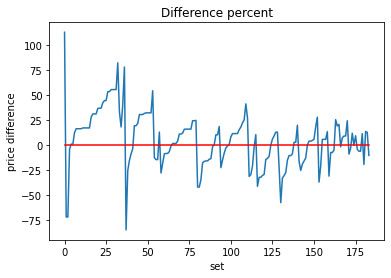

In [ ]:
fig, ax = plt.subplots()

ax.plot([x for _, x in sorted(zip(y_test_, pd.Series(difference_percent).drop([148,169])))])
ax.plot([0]*(len(difference_percent)-2), c='r')
ax.set_xlabel('set')
ax.set_ylabel("price difference")
ax.set_title("Difference percent");

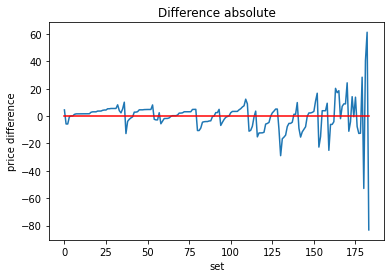

In [ ]:
fig, ax = plt.subplots()

ax.plot([x for _, x in sorted(zip(y_test_, pd.Series(difference_absolute).drop([148,169])))])
ax.plot([0]*(len(difference_percent)-2), c='r')
ax.set_xlabel('set')
ax.set_ylabel("price difference")
ax.set_title("Difference absolute");

##Conclusion

Even though the model performs reasonably well according to the machine learning metrics, I would advise against using it for any real world tasks, since on average we overestimate or underestimate the price of a given set by about 15-20 percent, which would undoubtedly cause severe finacial losses to the company

##Interpretation

In [ ]:
text_feature_names = bow_transformer_theme.get_feature_names_out()
numeric_feature_names = X_train_n.columns[gradboost_optimal_features_idx]

feature_names = np.concatenate([numeric_feature_names,text_feature_names])

importances = []

for ind, imp in enumerate(final_model[1].feature_importances_):
  if imp != 0:
    importances.append([feature_names[ind], imp])

for imp in sorted(importances, key = lambda x: x[1], reverse=True):
  print(imp[0], imp[1])

piece_count 0.8096544056927424
min_age 0.055379209720621644
serious play 0.03313916901614282
mindstorms 0.022462122069430403
wars 0.021089896583803173
star 0.017514543087647196
play 0.013937911636295361
serious 0.007116909802463535
star wars 0.006661958699130612
city 0.0024079242880994042
duplo 0.0015752492333533357
boost 0.0015585409439310297
ideas 0.001212832291265676
creator 0.0010885270890349666
classic 0.0010561823977560392
brickheadz 0.0008225913854018285
dimensions 0.0005757718141539571
lego ninjago 0.0005669446884080688
expert 0.0004935473530316786
ninjago 0.0003946906081353451
creator expert 0.0003267718402697976
ninjago movie 0.00014322496108395017
disney 0.0001360304443632607
architecture 7.887169862406486e-05
minecraft 7.321347401330425e-05
nexo knights 6.846277235545026e-05
nexo 4.955466680817026e-05
knights 4.8391806474751094e-05
champions 3.8983677005343695e-05
speed champions 3.7749241112436075e-05
power 3.55966101825918e-05
lockwood estate 3.3953058183091996e-05
speed 